In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df  = pivot_df.head(10000)


# Initialize parameters
alpha = 0.4
beta = 0.4
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.01    # Initial rate of change estimate
theta = 0.05  # Threshold for significant change
num_nodes_to_poll = 10  # Number of nodes to poll at each timestep (adjustable)
max_value = 40  # Maximum value to clamp to prevent overflow


# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

state_estimates = {f'mote{i}': initial_state for i in range(1, 21)}
rate_of_change = {f'mote{i}': initial_rate for i in range(1, 21)}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {f'mote{i}': initial_state for i in range(1, 21)}
last_update_times = {f'mote{i}': 0 for i in range(1, 21)}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 21)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 21)}

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    result = x_hat + x_rate * delta_t
    return np.clip(result, -max_value, max_value)  # Clamp the value to prevent overflow

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)[:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx
    delta_t_global = current_time_step - min(last_update_times.values())

    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t_global)

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        previous_state = state_estimates[mote]
        previous_rate = rate_of_change[mote]
        delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

        # Update state estimate using the provided formulas
        state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
        state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)  # Clamp the value to prevent overflow

        if delta_t != 0:
            rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
            rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)  # Clamp the value to prevent overflow

        predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
        
        if abs(measured_value - predicted_measurement) > theta:
            transmitted_count[mote] += 1

            last_sensed_values[mote] = measured_value
        
        # Store the data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')


# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)

Average MSE: 1.3707362274307409
Average sensor lifetime (years): 0.25471685584665105


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Initialize parameters
alpha = 0.04
beta = 0.1
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.01   # Initial rate of change estimate
theta = 0.5  # Threshold for significant change
num_nodes_to_poll = 10  # Number of nodes to poll at each timestep (adjustable)
max_value = 40  # Maximum value to clamp to prevent overflow

# Force pull threshold
force_pull_threshold = 200  # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

state_estimates = {f'mote{i}': initial_state for i in range(1, 51)}
rate_of_change = {f'mote{i}': initial_rate for i in range(1, 51)}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {f'mote{i}': initial_state for i in range(1, 51)}
last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 51)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    result = x_hat + x_rate * delta_t
    return np.clip(result, -max_value, max_value)  # Clamp the value to prevent overflow

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
    top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx
    delta_t_global = current_time_step - min(last_update_times.values())
    
    currently_polled_nodes = set()

    # Check if any node needs to be forcefully pulled due to inactivity
    for mote, last_time in last_update_times.items():
        if current_time_step - last_time >= force_pull_threshold:
            currently_polled_nodes.add(mote)
            #print(f"Force pulling mote: {mote} at time step: {current_time_step}")

    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes)

    # Include forced pull nodes in the top sensors list
    top_sensors = list(currently_polled_nodes) + top_sensors

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        previous_state = state_estimates[mote]
        previous_rate = rate_of_change[mote]
        delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

        # Update state estimate using the provided formulas
        state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
        state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)  # Clamp the value to prevent overflow

        if delta_t != 0:
            rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
            rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)  # Clamp the value to prevent overflow

        predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
        
        if abs(measured_value - predicted_measurement) > theta:
            transmitted_count[mote] += 1
            last_sensed_values[mote] = measured_value

            # Store the data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

        # Mark this node as polled in the current iteration
        currently_polled_nodes.add(mote)

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')

# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_df-50_dewma.csv', index=False)

Force pulling mote: mote22 at time step: 231
Force pulling mote: mote19 at time step: 238
Force pulling mote: mote11 at time step: 257
Force pulling mote: mote28 at time step: 287
Force pulling mote: mote32 at time step: 289
Force pulling mote: mote34 at time step: 291
Force pulling mote: mote36 at time step: 292
Force pulling mote: mote2 at time step: 307
Force pulling mote: mote16 at time step: 311
Force pulling mote: mote10 at time step: 312
Force pulling mote: mote6 at time step: 314
Force pulling mote: mote7 at time step: 317
Force pulling mote: mote9 at time step: 319
Force pulling mote: mote26 at time step: 321
Force pulling mote: mote24 at time step: 326
Force pulling mote: mote8 at time step: 328
Force pulling mote: mote3 at time step: 336
Force pulling mote: mote15 at time step: 341
Force pulling mote: mote4 at time step: 343
Force pulling mote: mote21 at time step: 346
Force pulling mote: mote23 at time step: 348
Force pulling mote: mote20 at time step: 350
Force pulling mot

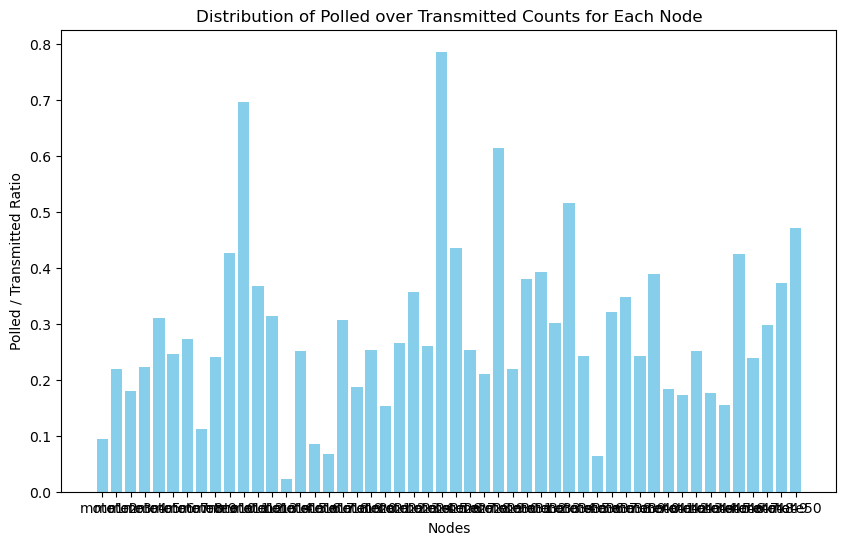

In [12]:
# Generate plot for distribution of polled over transmitted counts for each node
ratios = {mote:  transmitted_count[mote]/ polled_count[mote]  for mote in polled_count}

plt.figure(figsize=(10, 6))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Nodes')
plt.ylabel('Polled / Transmitted Ratio')
plt.title('Distribution of Polled over Transmitted Counts for Each Node')
plt.show()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Initialize parameters
alpha = 0.04
beta = 0.1
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.01   # Initial rate of change estimate
theta = 0.05  # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20, 50]  # List of numbers of nodes to poll
max_value = 40  # Maximum value to clamp to prevent overflow

# Force pull threshold
force_pull_threshold = 200  # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': initial_state for i in range(1, 51)}
    rate_of_change = {f'mote{i}': initial_rate for i in range(1, 51)}
    
    last_sensed_values = {f'mote{i}': initial_state for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    def predict_node_state(x_hat, x_rate, delta_t):
        result = x_hat + x_rate * delta_t
        return np.clip(result, -max_value, max_value)
    
    def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes):
        predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
        value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
        top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
        top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
        return top_nodes

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        delta_t_global = current_time_step - min(last_update_times.values())
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)
                #print(f"Force pulling mote: {mote} at time step: {current_time_step}")

        top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes)
        top_sensors = list(currently_polled_nodes) + top_sensors

        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_rate = rate_of_change[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
            state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)

            if delta_t != 0:
                rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
                rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)

            predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
            
            if abs(measured_value - predicted_measurement) > theta:
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': predicted_measurement,
                    'time_elapsed': delta_t
                })

            currently_polled_nodes.add(mote)

        for mote in top_sensors:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Running simulation for 50 nodes to poll...
Completed simulation for 50 nodes to poll.
Nodes to poll: 1
  Average MSE: 106.81874246010209
  Average sensor lifetime (years): 2.9018731049143356
Nodes to poll: 2
  Average MSE: 8.79191611732382
  Average sensor lifetime (years): 1.516080304543876
Nodes to poll: 5
  Average MSE: 5.16185510194989
  Average sensor lifetime (years): 0.6280739301484758
Nodes to poll: 10
  Average MSE: 3.843567816078045
  Average sensor lifetime (years): 0.3197460780522517
Nodes to poll: 20
  Average MSE: 2.5898823245605236
  Average sensor lifeti

# Humidity 

In [34]:
pivot_df = pd.read_csv('top_fifty_motes_light.csv')
pivot_df['mote50'].mean()

262.73934934487204

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_light.csv')
pivot_df = pivot_df.head(3000)

# Initialize parameters
alpha = 0.2
beta = 0.2
initial_state = 300.0  # Initial temperature estimate
initial_rate = 0.2   # Initial rate of change estimate
theta = 0.5  # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5, 10, 20]  # List of numbers of nodes to poll
max_value = 40  # Maximum value to clamp to prevent overflow

# Force pull threshold
force_pull_threshold = 200  # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': initial_state for i in range(1, 51)}
    rate_of_change = {f'mote{i}': initial_rate for i in range(1, 51)}
    
    last_sensed_values = {f'mote{i}': initial_state for i in range(1, 51)}
    last_update_times = {f'mote{i}': 300 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    def predict_node_state(x_hat, x_rate, delta_t):
        result = x_hat + x_rate * delta_t
        return np.clip(result, -max_value, max_value)
    
    def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes):
        predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t[mote]) for mote in state_estimates}
        value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
        top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
        top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
        return top_nodes


    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        delta_t = {mote: current_time_step - last_time for mote, last_time in last_update_times.items()}
        
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)
                #print(f"Force pulling mote: {mote} at time step: {current_time_step}")

        top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes)
        top_sensors = list(currently_polled_nodes) + top_sensors

        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_rate = rate_of_change[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
            state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)

            if delta_t != 0:
                rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
                rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)

            predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
            
            if abs(measured_value - predicted_measurement) > theta:
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'humidity': measured_value,
                    'predicted_humidity': predicted_measurement,
                    'time_elapsed': delta_t
                })

            currently_polled_nodes.add(mote)

        for mote in top_sensors:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['humidity'] - valuable_sensor_df['predicted_humidity']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years

results = {}

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")


Running simulation for 1 nodes to poll...
Completed simulation for 1 nodes to poll.
Running simulation for 2 nodes to poll...
Completed simulation for 2 nodes to poll.
Running simulation for 5 nodes to poll...
Completed simulation for 5 nodes to poll.
Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 1
  Average MSE: 1224939.5417729924
  Average sensor lifetime (years): 3.1439060190660584
Nodes to poll: 2
  Average MSE: 1586010.2053586617
  Average sensor lifetime (years): 3.0234370957342547
Nodes to poll: 5
  Average MSE: 2082502.2050658097
  Average sensor lifetime (years): 1.9829127416183912
Nodes to poll: 10
  Average MSE: 1443884.7213165856
  Average sensor lifetime (years): 0.6942965000296296
Nodes to poll: 20
  Average MSE: 886902.6706184518
  Average sensor lifetime (years): 0.21000932085117185


: 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_light.csv')
pivot_df = pivot_df.head(3000)

# Initialize parameters
initial_state = 300.0  # Initial temperature estimate
initial_rate = 0.05   # Initial rate of change estimate
theta = 0.5  # Threshold for significant change
num_nodes_to_poll_list = [1, 2, 5]  # List of numbers of nodes to poll
max_value = 40  # Maximum value to clamp to prevent overflow

# Force pull threshold
force_pull_threshold = 200  # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def run_simulation(alpha, beta, num_nodes_to_poll):
    state_estimates = {f'mote{i}': initial_state for i in range(1, 51)}
    rate_of_change = {f'mote{i}': initial_rate for i in range(1, 51)}
    
    last_sensed_values = {f'mote{i}': initial_state for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    
    def predict_node_state(x_hat, x_rate, delta_t):
        result = x_hat + x_rate * delta_t
        return np.clip(result, -max_value, max_value)
    
    def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes):
        predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t[mote]) for mote in state_estimates}
        value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
        top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
        top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
        return top_nodes


    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        delta_t = {mote: current_time_step - last_time for mote, last_time in last_update_times.items()}
        
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)
                #print(f"Force pulling mote: {mote} at time step: {current_time_step}")

        top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes)
        top_sensors = list(currently_polled_nodes) + top_sensors

        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_rate = rate_of_change[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
            state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)

            if delta_t != 0:
                rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
                rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)

            predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
            
            if abs(measured_value - predicted_measurement) > theta:
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'humidity': measured_value,
                    'predicted_humidity': predicted_measurement,
                    'time_elapsed': delta_t
                })

            currently_polled_nodes.add(mote)

        for mote in top_sensors:
            last_update_times[mote] = current_time_step

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    valuable_sensor_df['squared_error'] = (valuable_sensor_df['humidity'] - valuable_sensor_df['predicted_humidity']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years

results = {}

for alpha in np.linspace(0, 1, 10):  # Loop through different alpha values
    for beta in np.linspace(0, 1, 10):  # Loop through different beta values
        for num_nodes_to_poll in num_nodes_to_poll_list:
            print(f"Running simulation for alpha={alpha}, beta={beta}, {num_nodes_to_poll} nodes to poll...")
            mse, lifetime = run_simulation(alpha, beta, num_nodes_to_poll)
            results[(alpha, beta, num_nodes_to_poll)] = {'MSE': mse, 'Lifetime (years)': lifetime}
            print(f"Completed simulation for alpha={alpha}, beta={beta}, {num_nodes_to_poll} nodes to poll.")

# Print the results
for params, metrics in results.items():
    alpha, beta, num_nodes_to_poll = params
    print(f"Alpha: {alpha}, Beta: {beta}, Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")


Running simulation for alpha=0.0, beta=0.0, 1 nodes to poll...
Completed simulation for alpha=0.0, beta=0.0, 1 nodes to poll.
Running simulation for alpha=0.0, beta=0.0, 2 nodes to poll...
Completed simulation for alpha=0.0, beta=0.0, 2 nodes to poll.
Running simulation for alpha=0.0, beta=0.0, 5 nodes to poll...
Completed simulation for alpha=0.0, beta=0.0, 5 nodes to poll.
Running simulation for alpha=0.0, beta=0.1111111111111111, 1 nodes to poll...
Completed simulation for alpha=0.0, beta=0.1111111111111111, 1 nodes to poll.
Running simulation for alpha=0.0, beta=0.1111111111111111, 2 nodes to poll...
Completed simulation for alpha=0.0, beta=0.1111111111111111, 2 nodes to poll.
Running simulation for alpha=0.0, beta=0.1111111111111111, 5 nodes to poll...
Completed simulation for alpha=0.0, beta=0.1111111111111111, 5 nodes to poll.
Running simulation for alpha=0.0, beta=0.2222222222222222, 1 nodes to poll...
Completed simulation for alpha=0.0, beta=0.2222222222222222, 1 nodes to poll

Running simulation for 20 nodes to poll...
Completed simulation for 20 nodes to poll.
Nodes to poll: 20
  Average MSE: 4.218108292579138
  Average sensor lifetime (years): 0.221916799283954


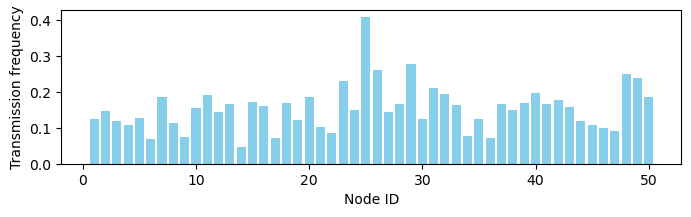

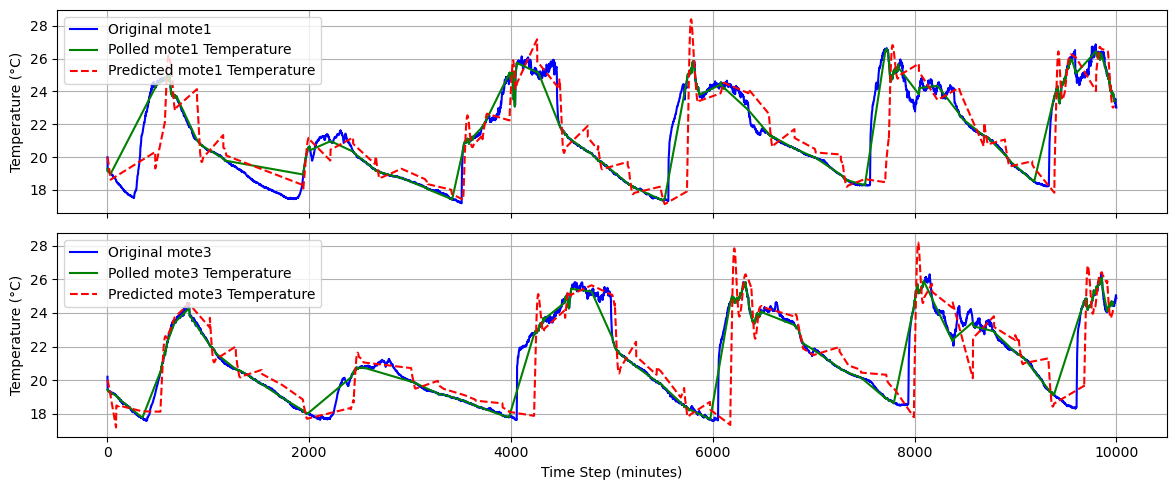

: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pivot_df.head(10000)

# Initialize parameters
alpha = 0.04
beta = 0.1
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.01   # Initial rate of change estimate
theta = 0.3  # Threshold for significant change
num_nodes_to_poll_list = [20]  # List of numbers of nodes to poll at each timestep
max_value = 40  # Maximum value to clamp to prevent overflow

# Force pull threshold
force_pull_threshold = 200  # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    result = x_hat + x_rate * delta_t
    return np.clip(result, -max_value, max_value)  # Clamp the value to prevent overflow

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t, currently_polled_nodes):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)
    top_nodes = [node for node in top_nodes if node not in currently_polled_nodes][:num_nodes_to_poll]
    return top_nodes

# Main simulation function
def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': initial_state for i in range(1, 51)}
    rate_of_change = {f'mote{i}': initial_rate for i in range(1, 51)}

    # Initialize previous timestamps for delta time calculation
    last_sensed_values = {f'mote{i}': initial_state for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}

    # Initialize a list to store the most valuable sensor data and the associated metadata
    valuable_sensor_data = []

    # Initialize tracking arrays
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}

    # Simulation loop
    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        delta_t_global = current_time_step - min(last_update_times.values())

        currently_polled_nodes = set()

        # Check if any node needs to be forcefully pulled due to inactivity
        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)
                #print(f"Force pulling mote: {mote} at time step: {current_time_step}")

        # Predict the sensor with the most significant changes
        top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t_global, currently_polled_nodes)

        # Include forced pull nodes in the top sensors list
        top_sensors = list(currently_polled_nodes) + top_sensors

        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_rate = rate_of_change[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

            # Update state estimate using the provided formulas
            state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
            state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)  # Clamp the value to prevent overflow

            if delta_t != 0:
                rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
                rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)  # Clamp the value to prevent overflow

            predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
            
            if abs(measured_value - predicted_measurement) > theta:
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                # Store the data
                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': predicted_measurement,
                    'time_elapsed': delta_t
                })

            # Mark this node as polled in the current iteration
            currently_polled_nodes.add(mote)

        # Update the last selected index for the most valuable mote
        for mote in top_sensors:
            last_update_times[mote] = current_time_step

    # Convert the list to a DataFrame
    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

    # Calculate the average MSE
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    # Calculate polling and transmission fractions
    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    # Calculate the average lifetime of sensors in hours and years
    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years

    return average_mse, average_lifetime_years, transmitted_count, valuable_sensor_df

# Run simulations for multiple num_nodes_to_poll values
results = {}
valuable_sensor_df_list = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, transmitted_count, valuable_sensor_df = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    valuable_sensor_df_list.append((num_nodes_to_poll, valuable_sensor_df))
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Plot the total transmission count for each node against the total simulation time steps
total_duration = len(pivot_df)
ratios = {int(mote.replace('mote', '')): transmitted_count[mote] / total_duration for mote in transmitted_count}

plt.figure(figsize=(8, 2))
plt.bar(ratios.keys(), ratios.values(), color='skyblue')
plt.xlabel('Node ID')
plt.ylabel('Transmission frequency')

# Set x-ticks at intervals of 10
plt.xticks()
ticks = list(range(0, 51, 10))
plt.xticks(ticks)

plt.show()

# Plot valuable_sensor_df data for each simulation
for num_nodes_to_poll, valuable_sensor_df in valuable_sensor_df_list:
    if num_nodes_to_poll % 10 == 0:  # Plot only for multiples of 10
        fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

        for i, mote in enumerate(['mote1', 'mote3']):
            # Plot original data from the node end
            axs[i].plot(pivot_df['SN'], pivot_df[mote], 'b-', label=f'Original {mote}')
            
            # Plot data collected from the sink end
            mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
            axs[i].plot(mote_data['index'], mote_data['temperature'], 'g-', label=f'Polled {mote} Temperature')
            axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label=f'Predicted {mote} Temperature')
            
            axs[i].set_ylabel('Temperature (°C)')
            axs[i].legend()
            axs[i].grid(True)

        axs[-1].set_xlabel('Time Step (minutes)')
        plt.tight_layout()
        plt.show()
